In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Carregar o modelo

In [12]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

[12/09 05:04:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Carregar dataset de car-damage

In [15]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

!curl -L "https://universe.roboflow.com/ds/5sncDNZAeT?key=lgL2BuIUSz" > roboflow.zip; unzip roboflow.zip -d datasets/car-damage-s4; rm roboflow.zip


# Replace with paths to your dataset
# register_coco_instances("car-damage-v8-train", {}, "datasets/car-damage-v8/train/_annotations.coco.json", "datasets/car-damage-v8/train")
# register_coco_instances("car-damage-v8-test", {}, "datasets/car-damage-v8/valid/_annotations.coco.json", "datasets/car-damage-v8/valid")
register_coco_instances("car-damage-s4-train", {}, "datasets/car-damage-s4/train/_annotations.coco.json", "datasets/car-damage-s4/train")
register_coco_instances("car-damage-s4-test", {}, "datasets/car-damage-s4/test/_annotations.coco.json", "datasets/car-damage-s4/test")

# Verify if the dataset is correctly registered
my_dataset_metadata = MetadataCatalog.get("car-damage-s4-train")
dataset_dicts = DatasetCatalog.get("car-damage-s4-train")



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3193      0 --:--:-- --:--:-- --:--:--  3195
100 37.6M  100 37.6M    0     0  11.5M      0  0:00:03  0:00:03 --:--:-- 13.6M
Archive:  roboflow.zip
  inflating: datasets/car-damage-s4/README.dataset.txt  
  inflating: datasets/car-damage-s4/README.roboflow.txt  
   creating: datasets/car-damage-s4/test/
 extracting: datasets/car-damage-s4/test/0477_JPEG_jpg.rf.712357b59ef0b79c8d70d19d9fb4d1b5.jpg  
 extracting: datasets/car-damage-s4/test/0914_JPEG_jpg.rf.4c07f38d06b9678641937c0ee7d3f0db.jpg  
 extracting: datasets/car-damage-s4/test/1103_jpeg_jpg.rf.6c485e452fcaeddfaf5b014e3bb8b694.jpg  
 extracting: datasets/car-damage-s4/test/1103_jpeg_jpg.rf.e0e7c8526cd48255923d0cb9f59a6ba4.jpg  
 extracting: datasets/car-damage-s4/test/134_jpg.rf.c00d28d5acdcfcafb515897f02beb565.jpg  
 extracting: datasets/car

Selecionar modelo e treinar dataset de treino

In [21]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #
cfg.DATASETS.TRAIN = ("car-damage-s4-train",)
cfg.DATASETS.TEST = ("car-damage-s4-test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 200 #2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
#cfg.OUTPUT_DIR = "./output"

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 07:38:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[12/09 07:38:59 d2.engine.train_loop]: Starting training from iteration 0
[12/09 07:39:04 d2.utils.events]:  eta: 0:00:47  iter: 19  total_loss: 3.056  loss_cls: 1.546  loss_box_reg: 0.5174  loss_mask: 0.6931  loss_rpn_cls: 0.2821  loss_rpn_loc: 0.02707    time: 0.2700  last_time: 0.3011  data_time: 0.0077  last_data_time: 0.0027   lr: 9.5905e-06  max_mem: 1947M
[12/09 07:39:10 d2.utils.events]:  eta: 0:00:44  iter: 39  total_loss: 2.852  loss_cls: 1.336  loss_box_reg: 0.5716  loss_mask: 0.6911  loss_rpn_cls: 0.1337  loss_rpn_loc: 0.02046    time: 0.2785  last_time: 0.2169  data_time: 0.0030  last_data_time: 0.0024   lr: 1.958e-05  max_mem: 1947M
[12/09 07:39:15 d2.utils.events]:  eta: 0:00:38  iter: 59  total_loss: 2.446  loss_cls: 1.058  loss_box_reg: 0.4496  loss_mask: 0.6882  loss_rpn_cls: 0.1744  loss_rpn_loc: 0.02973    time: 0.2744  last_time: 0.2796  data_time: 0.0027  last_data_time: 0.0024   lr: 2.9571e-05  max_mem: 1947M
[12/09 07:39:21 d2.utils.events]:  eta: 0:00:32  iter:

Evaluate

In [22]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
#TODO: rodar apenas com a rede já treinada (parâmetros no /output)


# Configurações para o modelo treinado
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Ajuste o threshold de detecção, se necessário
cfg.DATASETS.TEST = ("car-damage-s4-test",)


In [23]:


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("car-damage-s4-test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car-damage-s4-test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[12/09 07:54:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/09 07:54:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/09 07:54:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 07:54:46 d2.data.datasets.coco]: Loaded 89 images in COCO format from datasets/car-damage-s4/test/_annotations.coco.json
[12/09 07:54:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 07:54:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 07:54:46 d2.data.common]: Serializing 89 elements to byte tensors and concatenating them all ...
[12/09 07:54:46 d2.data.common]: Serialized datase

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/09 07:55:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Printar resultados

WARNING [12/09 08:07:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 08:07:18 d2.data.datasets.coco]: Loaded 89 images in COCO format from datasets/car-damage-s4/test/_annotations.coco.json


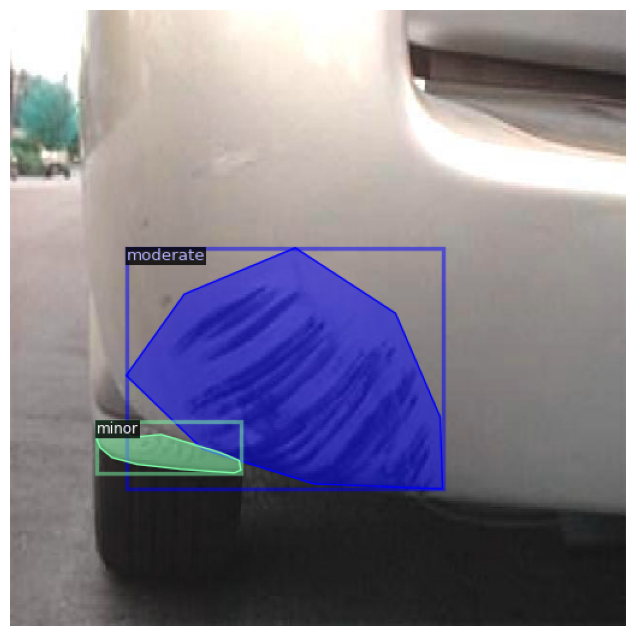

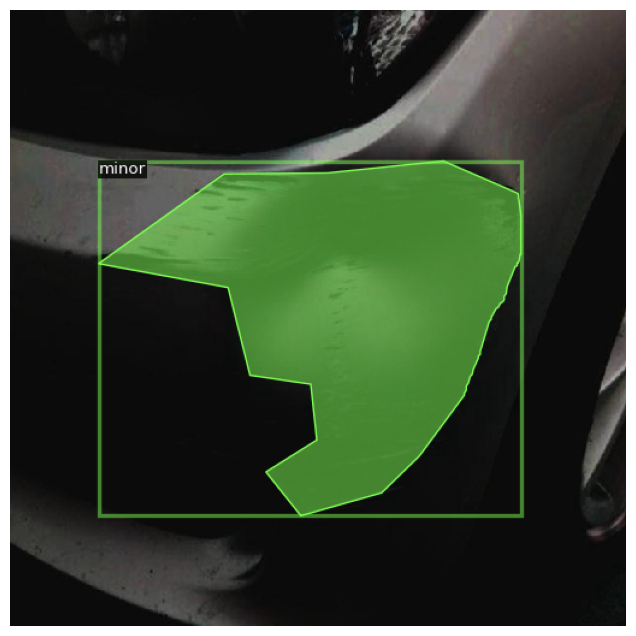

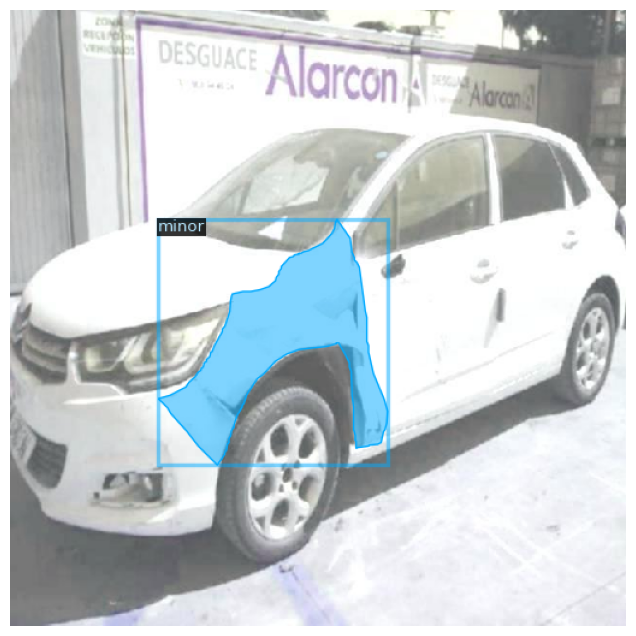

In [27]:
''
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Get the dataset metadata and dataset dicts
dataset_dicts = DatasetCatalog.get("car-damage-s4-test")
metadata = MetadataCatalog.get("car-damage-s4-test")

# Plot a few random images from the dataset
for d in random.sample(dataset_dicts, 3):  # Change the number to print more or fewer images
    img = cv2.imread(d["file_name"])

    # Create a visualizer and draw annotations (bounding boxes, etc.)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Display the image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

Testar uma imagem qualquer

In [34]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

# Configurações para o modelo treinado
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Threshold para a detecção
cfg.DATASETS.TEST = ("car-damage-s4-test",)  # Dataset de teste (opcional)

# Inicializa o preditor
predictor = DefaultPredictor(cfg)

# Carregar a imagem aleatória fora do dataset
image_path = "teste.jpg"  # Substitua com o caminho da imagem que você deseja testar
im = cv2.imread(image_path)


# Fazer a inferência
outputs = predictor(im)

if len(outputs["instances"]) > 0:
    v = Visualizer(im[:, :, ::-1], scale=1.2, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Mostrar a imagem com as previsões
    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
else:
    print("Nenhuma previsão foi detectada.")

[12/09 08:43:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (5, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (16, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (16,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (4, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) 

Nenhuma previsão foi detectada.
